In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax

def s(arr):
    return pd.DataFrame(arr)

np.random.seed(42)
train = pd.read_csv('fashion-mnist_train.csv')
test = pd.read_csv('fashion-mnist_test.csv')
train = np.array(train)
test = np.array(test)
np.random.shuffle(train)
np.random.shuffle(test)
train = train[:10000]
train_y = train[:,0]
train = train[:,1:]
test = test[:5000]
test_y = test[:,0]
test = test[:,1:]

Actual: Sneaker
Predicted: T-shirt/top


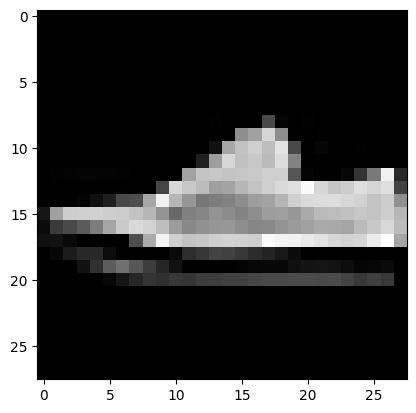

In [76]:
s(train)
def show_image(image, label, actual_label):
    labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    print('Actual:',labels[actual_label])
    print('Predicted:',labels[label])
    plt.imshow(image.reshape(28,28), cmap='gray')
    plt.show()
    
# show the first image in the training set
show_image(train[0,:], 0, train_y[0])

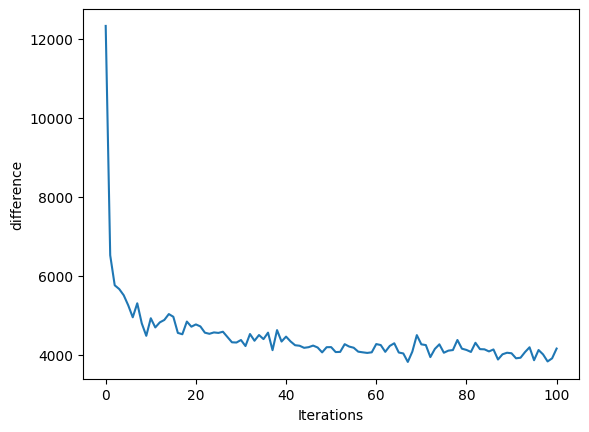

In [77]:
# logistic regression
# augment the data with a column of ones
def multiclass_logistic_regression(X, y_, eta, epsilon, max_iter):
    K = len(np.unique(y_))
    d = X.shape[1]
    X = np.hstack((np.ones((X.shape[0],1)), X))
    y = np.zeros((X.shape[0], K))
    for i in range(X.shape[0]):
        y[i, y_[i]] = 1

    t = 0
    w = np.random.rand(d+1, K)
    diffs = []
    while True:
        w_old = w
        for i in np.random.permutation(X.shape[0]):
            x = X[i,:]
            pi = softmax(np.dot(x, w))
            w = w + eta * np.outer(x, y[i,:] - pi)
        t += 1
        diff = np.linalg.norm(w - w_old)
        diffs.append(diff)
        if diff < epsilon or t > max_iter:
            break
    # plot diffs
    plt.plot(diffs)
    # x label: iterations
    plt.xlabel('Iterations')
    # y label: difference
    plt.ylabel('difference')
    plt.show()
    return w

w = multiclass_logistic_regression(train, train_y, 0.1, 1000, 100)
 

Training accuracy: 0.8914
Test accuracy: 0.797 

T-shirt/top 0.75
Trouser 0.94
Pullover 0.71
Dress 0.81
Coat 0.72
Sandal 0.84
Shirt 0.44
Sneaker 0.87
Bag 0.9
Ankle boot 0.88


Actual: Coat
Predicted: Shirt


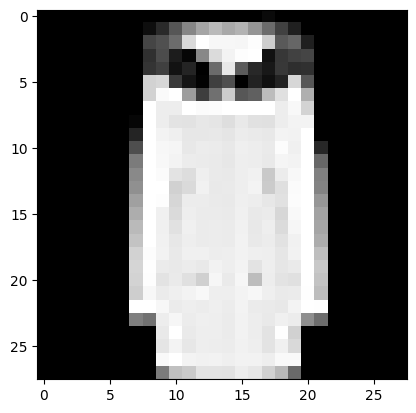



Actual: Ankle boot
Predicted: Ankle boot


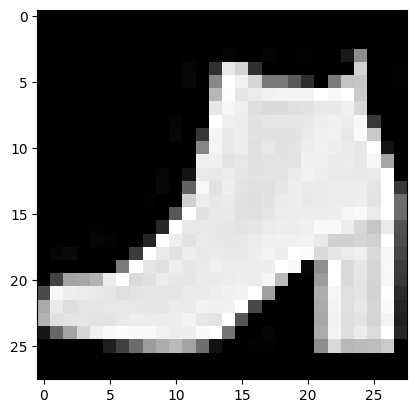



Actual: Dress
Predicted: Dress


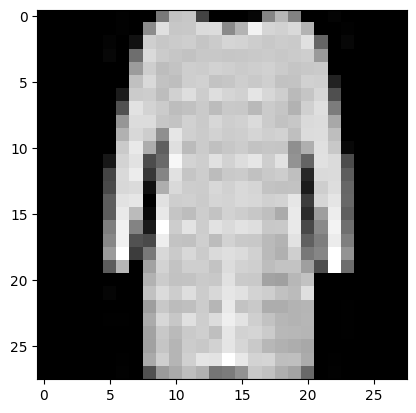



Actual: Ankle boot
Predicted: Ankle boot


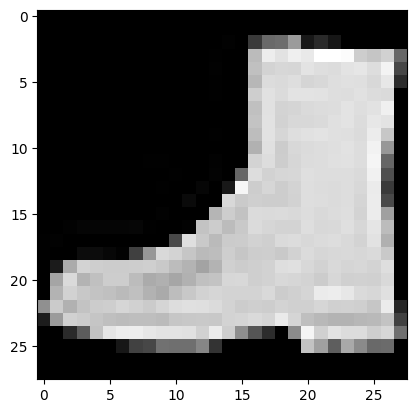



Actual: Shirt
Predicted: T-shirt/top


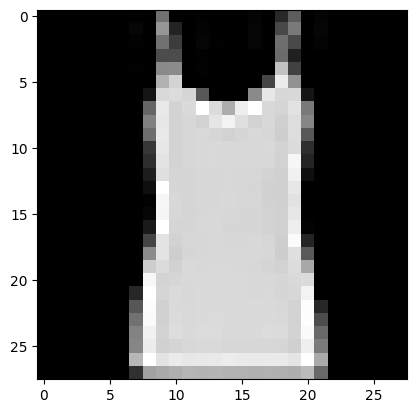



Actual: Pullover
Predicted: Pullover


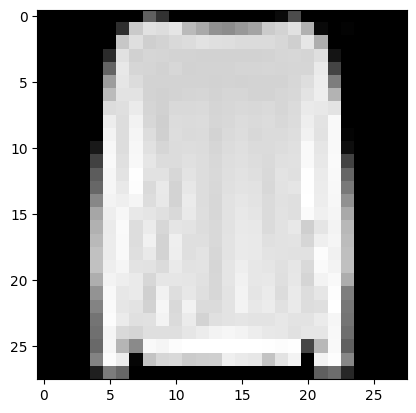



Actual: Pullover
Predicted: Pullover


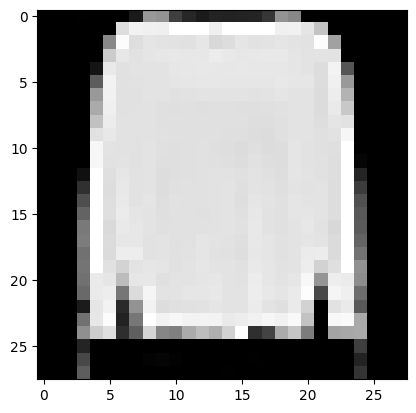



Actual: Sandal
Predicted: Sandal


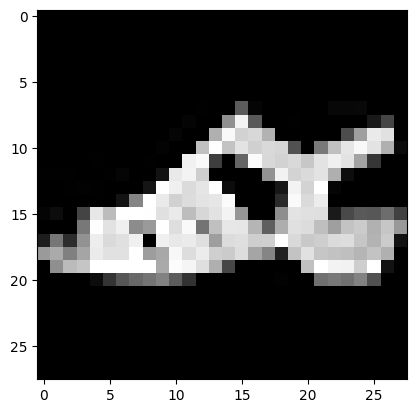



Actual: Shirt
Predicted: Shirt


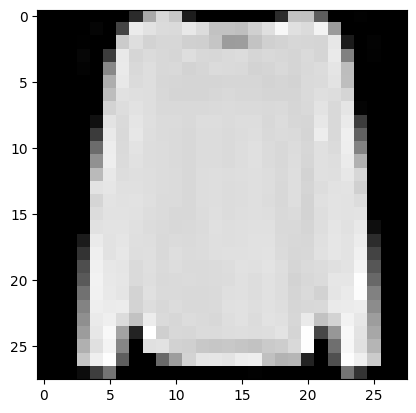



Actual: Coat
Predicted: Coat


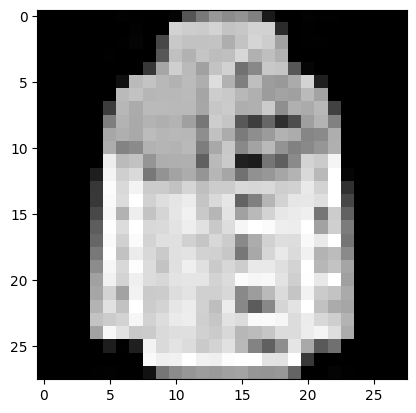

In [82]:
def predict(X, w):
    X = np.hstack((np.ones((X.shape[0],1)), X))
    y_hat = softmax(np.dot(X,w), axis=1)
    return np.argmax(y_hat, axis=1)

train_predictions = predict(train, w)
train_accuracy = np.mean(train_predictions == train_y)
print('Training accuracy:', train_accuracy)
test_predictions = predict(test, w)
test_accuracy = np.mean(test_predictions == test_y)
print('Test accuracy:', test_accuracy, '\n')

# calculate F1 score
def f1_score(y, y_hat):
    tp = np.sum((y == 1) & (y_hat == 1))
    fp = np.sum((y == 0) & (y_hat == 1))
    fn = np.sum((y == 1) & (y_hat == 0))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    return round(f1, 2)

# calculate F1 score for each class
def f1_score_per_class(y, y_hat):
    K = len(np.unique(y))
    f1s = []
    for k in range(K):
        f1s.append(f1_score(y == k, y_hat == k))
    return f1s

f1s = f1_score_per_class(test_y, test_predictions)
for label in  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']:
    print(label, f1s.pop(0))
    
# show first 10 predictions
for i in range(10):
    print('\n')
    show_image(test[i,:], test_predictions[i], test_y[i])